In [17]:
"""E. coli Gene Regulatory Network - Dual Regulator Analysis"""

import time

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

from y0.algorithm.identify import Unidentifiable, cyclic_id
from y0.dsl import P, Variable
from y0.graph import NxMixedGraph

# Set up nice plotting style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

print("=" * 60)
print("loading the data...")
print("=" * 60)

# Load E. coli regulatory network
print("\n1. Loading gene regulatory network...")
nx_graph = nx.read_graphml("ecoli_full_network_no_small_rna.graphml")
print(f"   ✓ Loaded: {nx_graph.number_of_nodes()} genes, {nx_graph.number_of_edges()} edges")

# Convert to y0 format
print("\n2. Converting to y0 format...")
edge_list = [(str(source), str(target)) for source, target in nx_graph.edges()]
ecoli_graph = NxMixedGraph.from_edges(directed=edge_list)
print(
    f"   ✓ Converted: {len(ecoli_graph.nodes())} nodes, {len(ecoli_graph.directed.edges())} edges"
)

# Create Variable objects for all genes
print("\n3. Creating variable objects...")
all_genes = {str(node): Variable(str(node)) for node in ecoli_graph.nodes()}
print(f"   ✓ Created {len(all_genes)} gene variables")

# Load experimental perturbation data
print("\n4. Loading ALL experimental perturbations...")
exp_data = pd.read_csv("supptable1.csv")

# Filter for high-throughput library
ht_data = exp_data[exp_data["Experiment"].str.contains("High-throughput", na=False)]

# Get unique gene targets (remove off-targets and controls)
perturbed_genes = ht_data["Perturbation Name"].unique()
perturbed_genes = [
    g
    for g in perturbed_genes
    if not str(g).startswith("CRISPRa off")
    and not str(g).startswith("CRISPRi off")
    and "control" not in str(g).lower()
    and "AAV" not in str(g)
]


genes_to_test = [g for g in perturbed_genes if g in all_genes]

print(f"   ✓ Total experimental perturbations: {len(perturbed_genes)}")
print(f"   ✓ Genes both perturbed AND in network: {len(genes_to_test)}")
print(f"\n   First 20 genes: {sorted(genes_to_test)[:20]}")
print(f"   ... and {len(genes_to_test) - 20} more")



loading the data...

1. Loading gene regulatory network...
   ✓ Loaded: 2976 genes, 9211 edges

2. Converting to y0 format...
   ✓ Converted: 2962 nodes, 9211 edges

3. Creating variable objects...
   ✓ Created 2962 gene variables

4. Loading ALL experimental perturbations...
   ✓ Total experimental perturbations: 52
   ✓ Genes both perturbed AND in network: 42

   First 20 genes: ['arcA', 'argP', 'argR', 'aroK', 'bdcR', 'cecR', 'cpxR', 'cra', 'crp', 'decR', 'fnr', 'gadE', 'gcvR', 'glaR', 'glnG', 'glpR', 'hns', 'iclR', 'lgoR', 'lrp']
   ... and 22 more


In [ ]:
"""
Single Gene Perturbations Baseline
=============================================

Test all P(Y | do(X)) queries where X, Y are in our test set
Testing 1,722 queries on the full E. coli network and gives us a baseline of how much of the network is identifiable/unidentifiable under single-gene perturbations.
"""

print("=" * 60)
print("testing single-gene perturbations...")
print("=" * 60)
print(f"Testing {len(genes_to_test)} genes")
print(f"Total queries: {len(genes_to_test) * (len(genes_to_test) - 1)}\n")

# Results storage
single_gene_results = []
query_count = 0
start_time = time.time()

# Progress tracking
total_queries = len(genes_to_test) * (len(genes_to_test) - 1)
identifiable_so_far = 0

# Test all combinations where outcome ≠ intervention
for outcome_name in genes_to_test:
    outcome_var = all_genes[outcome_name]

    for intervention_name in genes_to_test:
        if outcome_name == intervention_name:
            continue

        intervention_var = all_genes[intervention_name]
        query_count += 1
        query_name = f"P({outcome_name} | do({intervention_name}))"

        # Try to identify
        try:
            result = cyclic_id(
                graph=ecoli_graph, outcomes={outcome_var}, interventions={intervention_var}
            )
            status = "IDENTIFIABLE"
            identifiable_so_far += 1
            result_expr = result.to_y0()
        except Unidentifiable:
            status = "UNIDENTIFIABLE"
            result_expr = None

        # Store result
        single_gene_results.append(
            {
                "outcome": outcome_name,
                "intervention": intervention_name,
                "query": query_name,
                "status": status,
                "result": result_expr,
            }
        )

        # Progress indicator every 100 queries
        if query_count % 100 == 0:
            elapsed = time.time() - start_time
            rate = query_count / elapsed
            remaining = (total_queries - query_count) / rate
            print(
                f"  Progress: {query_count:>4}/{total_queries} ({query_count / total_queries * 100:.1f}%) | "
                f"Identifiable so far: {identifiable_so_far} | "
                f"ETA: {remaining / 60:.1f} min"
            )

elapsed_time = time.time() - start_time

# Create DataFrame
df_single = pd.DataFrame(single_gene_results)

# Save to CSV
df_single.to_csv("single_gene_results.csv", index=False)

print(f"\n{'=' * 60}")
print("BASELINE RESULTS")
print(f"{'=' * 60}")
print(f"Total queries: {len(df_single)}")
print(f"Time elapsed: {elapsed_time:.2f} seconds ({elapsed_time / 60:.2f} minutes)")
print(f"Average per query: {elapsed_time / len(df_single) * 1000:.1f} ms")
print("✓ Results saved to: single_gene_results.csv")

identifiable_count = len(df_single[df_single["status"] == "IDENTIFIABLE"])
unidentifiable_count = len(df_single[df_single["status"] == "UNIDENTIFIABLE"])

print(
    f"\nIDENTIFIABLE:     {identifiable_count:>4} ({identifiable_count / len(df_single) * 100:.1f}%)"
)
print(
    f"UNIDENTIFIABLE:   {unidentifiable_count:>4} ({unidentifiable_count / len(df_single) * 100:.1f}%)"
)

# Show sample unidentifiable queries
print(f"\n{'=' * 60}")
print("SAMPLE UNIDENTIFIABLE QUERIES (candidates for context):")
print(f"{'=' * 60}")
unidentifiable_queries = df_single[df_single["status"] == "UNIDENTIFIABLE"]["query"].head(10)
for i, query in enumerate(unidentifiable_queries, 1):
    print(f"{i:>2}. {query}")

TESTING SINGLE GENE PERTURBATIONS
Testing 42 genes
Total queries: 1722

  Progress:  100/1722 (5.8%) | Identifiable so far: 65 | ETA: 890.0 min
  Progress:  200/1722 (11.6%) | Identifiable so far: 130 | ETA: 853.7 min
  Progress:  300/1722 (17.4%) | Identifiable so far: 194 | ETA: 796.8 min
  Progress:  400/1722 (23.2%) | Identifiable so far: 259 | ETA: 718.6 min
  Progress:  500/1722 (29.0%) | Identifiable so far: 328 | ETA: 667.3 min
  Progress:  600/1722 (34.8%) | Identifiable so far: 412 | ETA: 569.8 min
  Progress:  700/1722 (40.7%) | Identifiable so far: 479 | ETA: 516.9 min
  Progress:  800/1722 (46.5%) | Identifiable so far: 543 | ETA: 476.0 min
  Progress:  900/1722 (52.3%) | Identifiable so far: 608 | ETA: 424.9 min
  Progress: 1000/1722 (58.1%) | Identifiable so far: 671 | ETA: 376.8 min
  Progress: 1100/1722 (63.9%) | Identifiable so far: 737 | ETA: 331.6 min
  Progress: 1200/1722 (69.7%) | Identifiable so far: 814 | ETA: 273.6 min
  Progress: 1300/1722 (75.5%) | Identifiab

In [16]:
"""
loading the baseline results from the CSV file
"""

import pandas as pd

print("=" * 80)
print("LOADING BASELINE RESULTS")
print("=" * 80)

# Load baseline results
df_single = pd.read_csv("single_gene_results.csv")

print("\n✓ Loaded baseline results from: single_gene_results.csv")
print(f"  Total queries: {len(df_single):,}")
print(f"  Columns: {list(df_single.columns)}")

# Quick summary
identifiable_count = len(df_single[df_single["status"] == "IDENTIFIABLE"])
unidentifiable_count = len(df_single[df_single["status"] == "UNIDENTIFIABLE"])

print("\nQuick Summary:")
print(
    f"  Identifiable:   {identifiable_count:>4} ({identifiable_count / len(df_single) * 100:.1f}%)"
)
print(
    f"  Unidentifiable: {unidentifiable_count:>4} ({unidentifiable_count / len(df_single) * 100:.1f}%)"
)

# just some samples
print("\nSample rows:")
print(df_single.head())


LOADING BASELINE RESULTS

✓ Loaded baseline results from: single_gene_results.csv
  Total queries: 1,722
  Columns: ['outcome', 'intervention', 'query', 'status', 'result']

Quick Summary:
  Identifiable:   1209 (70.2%)
  Unidentifiable:  513 (29.8%)

Sample rows:
  outcome intervention               query          status  \
0    arcA         argP  P(arcA | do(argP))  UNIDENTIFIABLE   
1    arcA         torR  P(arcA | do(torR))  UNIDENTIFIABLE   
2    arcA          lrp   P(arcA | do(lrp))  UNIDENTIFIABLE   
3    arcA         aroK  P(arcA | do(aroK))    IDENTIFIABLE   
4    arcA         rpoS  P(arcA | do(rpoS))  UNIDENTIFIABLE   

                                              result  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3  Sum[acrR, adiY, alpA, argP, argR, basR, bglJ, ...  
4                                                NaN  


baseline bar chart visualization


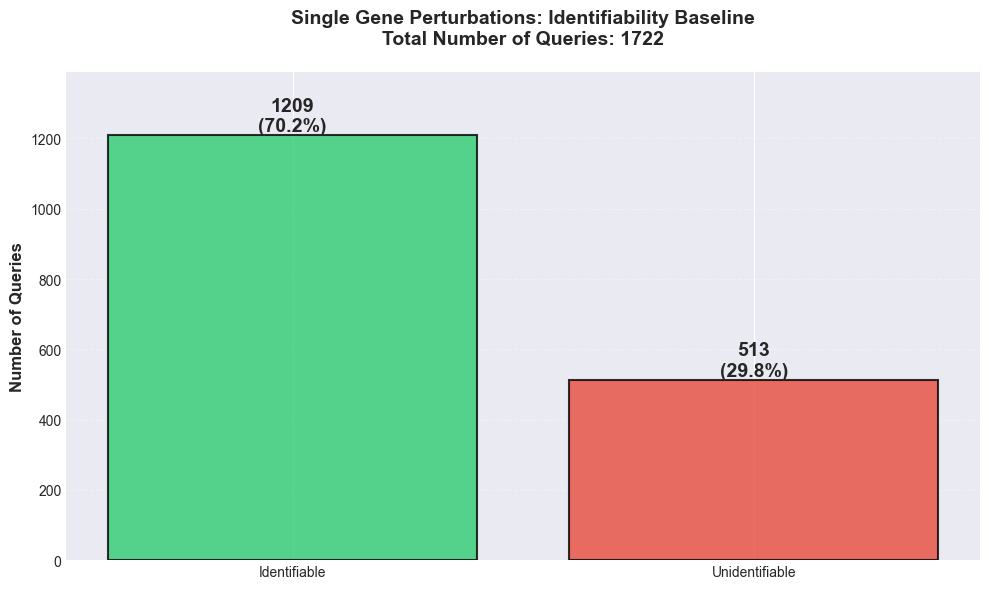


✓ Baseline visualization done.


In [4]:
"""
Visualizing the Single Gene Perturbation Results as a baseline
===============================================
"""

print("=" * 60)
print("baseline bar chart visualization")
print("=" * 60)

# Calculate counts
identifiable_count = len(df_single[df_single["status"] == "IDENTIFIABLE"])
unidentifiable_count = len(df_single[df_single["status"] == "UNIDENTIFIABLE"])

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Data for bar chart
categories = ["Identifiable", "Unidentifiable"]
counts = [identifiable_count, unidentifiable_count]
colors = ["#2ecc71", "#e74c3c"]  # Green for identifiable, red for unidentifiable

# Create bars
bars = ax.bar(categories, counts, color=colors, alpha=0.8, edgecolor="black", linewidth=1.5)

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{count}\n({count / len(df_single) * 100:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold",
    )

# Styling
ax.set_ylabel("Number of Queries", fontsize=12, fontweight="bold")
ax.set_title(
    "Single Gene Perturbations: Identifiability Baseline\n"
    f"Total Number of Queries: {len(df_single)}",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
ax.set_ylim(0, max(counts) * 1.15)
ax.grid(axis="y", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

print("\n✓ Baseline visualization done.")

In [ ]:
"""
Testing dual-regulatory pairs
"""

import networkx as nx

from y0.dsl import Variable
from y0.graph import NxMixedGraph

print("=" * 80)
print("analyzing...")
print("=" * 80)

# finding all genes with exactly 2 parents in the network
print("\n1. Finding genes with exactly 2 parents in the network...")

two_parent_genes = {}
for node in nx_graph.nodes():
    parents = list(nx_graph.predecessors(node))
    if len(parents) == 2:
        two_parent_genes[node] = parents

print(f"   ✓ Found {len(two_parent_genes)} genes with exactly 2 parents")
print(f"   Sample: {list(two_parent_genes.items())[:5]}")

# Filter to genes in the experimental data
print("\n2. Filtering to our 42-gene test set...")

two_parent_in_sample = {
    gene: parents for gene, parents in two_parent_genes.items() if gene in genes_to_test
}

print(f"   ✓ {len(two_parent_in_sample)} dual-regulated genes in our test set")
if two_parent_in_sample:
    print("\n   Genes with 2 parents:")
    for gene, parents in sorted(two_parent_in_sample.items()):
        print(f"      {gene} ← parents: {parents}")

# match with unidentifiable queries
print(
    f"\n3. Matching with {len(df_single[df_single['status'] == 'UNIDENTIFIABLE'])} unidentifiable queries..."
)

unidentifiable_df = df_single[df_single["status"] == "UNIDENTIFIABLE"].copy()

two_parent_opportunities = []
self_regulation_skipped = 0

for idx, row in unidentifiable_df.iterrows():
    outcome = row["outcome"]
    intervention = row["intervention"]

    # Check if outcome has exactly 2 parents
    if outcome in two_parent_genes:
        parents = two_parent_genes[outcome]

        # Check if intervention is one of the parents
        if intervention in parents:
            # Find the OTHER parent
            other_parent = [p for p in parents if p != intervention][0]

            # SKIP if other parent is the outcome itself (self-regulation)
            if other_parent == outcome:
                self_regulation_skipped += 1
                continue

            two_parent_opportunities.append(
                {
                    "outcome": outcome,
                    "intervention": intervention,
                    "other_parent": other_parent,
                    "original_query": f"P({outcome} | do({intervention}))",
                    "query_with_context": f"P({outcome} | do({intervention}), P[{other_parent}](V))",
                }
            )

print(f"   ✓ Found {len(two_parent_opportunities)} valid opportunities!")
if self_regulation_skipped > 0:
    print(f"   (Excluded {self_regulation_skipped} self-regulation cases)")

# Display any opportunities
print(f"\n{'=' * 80}")
print("Dual-regulated genes to test:")
print(f"{'=' * 80}")

if two_parent_opportunities:
    print("\nPattern: Gene with 2 co-regulators")
    print("         TF1 ─┐")
    print("              ├─→ Target Gene")
    print("         TF2 ─┘")
    print("\nHypothesis: If P(Target | do(TF1)) is unidentifiable,")
    print("            using TF2 as context should break the cycle\n")

    for i, opp in enumerate(two_parent_opportunities, 1):
        print(f"{i}. Target: {opp['outcome']}")
        print(f"   Co-regulators: {two_parent_genes[opp['outcome']]}")
        print(f"   Original:  {opp['original_query']} → UNIDENTIFIABLE")
        print(f"   With context: {opp['query_with_context']}")
        print()
else:
    print("\nNone found. Might need to retest.")

analyzing...

1. Finding genes with exactly 2 parents in the network...
   ✓ Found 671 genes with exactly 2 parents
   Sample: [('aaeA', ['aaeR', 'crp']), ('aaeB', ['aaeR', 'crp']), ('aaeX', ['aaeR', 'crp']), ('agaR', ['agaR', 'rpoD']), ('agaB', ['agaR', 'rpoD'])]

2. Filtering to our 42-gene test set...
   ✓ 10 dual-regulated genes in our test set

   Genes with 2 parents:
      argP ← parents: ['phoB', 'argP']
      aroK ← parents: ['argR', 'rpoD']
      cecR ← parents: ['cecR', 'rpoD']
      cra ← parents: ['phoB', 'rpoH']
      phnF ← parents: ['phoB', 'rpoD']
      sfsB ← parents: ['bglJ', 'rcsB']
      sgcR ← parents: ['crp', 'slyA']
      torR ← parents: ['rpoD', 'torR']
      trpR ← parents: ['rpoD', 'trpR']
      yciT ← parents: ['rpoS', 'lrp']

3. Matching with 513 unidentifiable queries...
   ✓ Found 7 valid opportunities!
   (Excluded 1 self-regulation cases)

Dual-regulated genes to test:

Pattern: Gene with 2 co-regulators
         TF1 ─┐
              ├─→ Target Gene
   

In [ ]:
"""
Do we actually gain some kind of information when we add the second perturbation?
"""

import time

from y0.algorithm.identify import Unidentifiable, cyclic_id

print("=" * 80)
print("testing on the dual-regulated genes...")
print("=" * 80)

# Create the set of all gene variables for P[J](V)
all_vars_set = set(all_genes.values())
print(f"\nPrepared context distribution with {len(all_vars_set)} genes")

two_parent_results = []
start_time = time.time()

print(f"\nTesting {len(two_parent_opportunities)} queries...\n")

for i, opp in enumerate(two_parent_opportunities, 1):
    outcome_name = opp["outcome"]
    intervention_name = opp["intervention"]
    context_name = opp["other_parent"]

    outcome_var = all_genes[outcome_name]
    intervention_var = all_genes[intervention_name]
    context_var = all_genes[context_name]

    print(f"{i}. Testing: P({outcome_name} | do({intervention_name}), P[{context_name}](V))")

    test_start = time.time()

    try:
        result = cyclic_id(
            graph=ecoli_graph,
            outcomes={outcome_var},
            interventions={intervention_var},
            query_initial_distribution=P[context_var](all_vars_set),
        )
        status = "IDENTIFIABLE"
        result_expr = result.to_y0()

        test_time = time.time() - test_start
        print(f"   ✓ IDENTIFIABLE! (took {test_time:.1f}s)")

        two_parent_results.append(
            {
                **opp,
                "status": status,
                "result": result_expr,
                "hypothesis_confirmed": "YES",
                "time_seconds": test_time,
            }
        )

    except Unidentifiable:
        status = "UNIDENTIFIABLE"
        test_time = time.time() - test_start
        print(f"   ✗ Still unidentifiable (took {test_time:.1f}s)")

        two_parent_results.append(
            {
                **opp,
                "status": status,
                "result": None,
                "hypothesis_confirmed": "NO",
                "time_seconds": test_time,
            }
        )

    print()

# Calculate statistics
total_time = time.time() - start_time

print(f"{'=' * 80}")
print("RESULTS SUMMARY")
print(f"{'=' * 80}")

df_two_parent = pd.DataFrame(two_parent_results)
df_two_parent.to_csv("two_parent_results_42gene.csv", index=False)

confirmed = len(df_two_parent[df_two_parent["hypothesis_confirmed"] == "YES"])
total = len(df_two_parent)

print(f"\nTests completed: {total}")
print(f"Total time: {total_time / 60:.1f} minutes")
print(f"Average per test: {total_time / total:.1f} seconds")
print(f"\nHypothesis confirmed: {confirmed}/{total} ({confirmed / total * 100:.1f}%)")

if confirmed == total:
    print("\n🎉 100% SUCCESS!")
    print("   All dual-regulatory queries became identifiable with co-regulator context!")
elif confirmed >= total * 0.8:
    print(f"\n✓ STRONG SUPPORT! ({confirmed / total * 100:.1f}% success rate)")
elif confirmed > 0:
    print(f"\n✓ PARTIAL SUPPORT ({confirmed}/{total} successes)")
else:
    print("\nNeeds some more work. ")

print("\n✓ Results saved to: two_parent_results_42gene.csv")
print(f"{'=' * 80}")

TESTING DUAL-REGULATORY HYPOTHESIS

Prepared context distribution with 2962 genes

Testing 7 queries...

1. Testing: P(aroK | do(argR), P[rpoD](V))
   ✓ IDENTIFIABLE! (took 5.6s)

2. Testing: P(phnF | do(phoB), P[rpoD](V))
   ✓ IDENTIFIABLE! (took 4.1s)

3. Testing: P(yciT | do(lrp), P[rpoS](V))
   ✓ IDENTIFIABLE! (took 9.7s)

4. Testing: P(yciT | do(rpoS), P[lrp](V))
   ✓ IDENTIFIABLE! (took 4.3s)

5. Testing: P(cra | do(rpoH), P[phoB](V))
   ✗ Still unidentifiable (took 3.9s)

6. Testing: P(cra | do(phoB), P[rpoH](V))
   ✗ Still unidentifiable (took 5.3s)

7. Testing: P(sgcR | do(crp), P[slyA](V))
   ✓ IDENTIFIABLE! (took 4.9s)

RESULTS SUMMARY

Tests completed: 7
Total time: 0.6 minutes
Average per test: 5.4 seconds

Hypothesis confirmed: 5/7 (71.4%)

✓ PARTIAL SUPPORT (5/7 successes)

✓ Results saved to: two_parent_results_42gene.csv


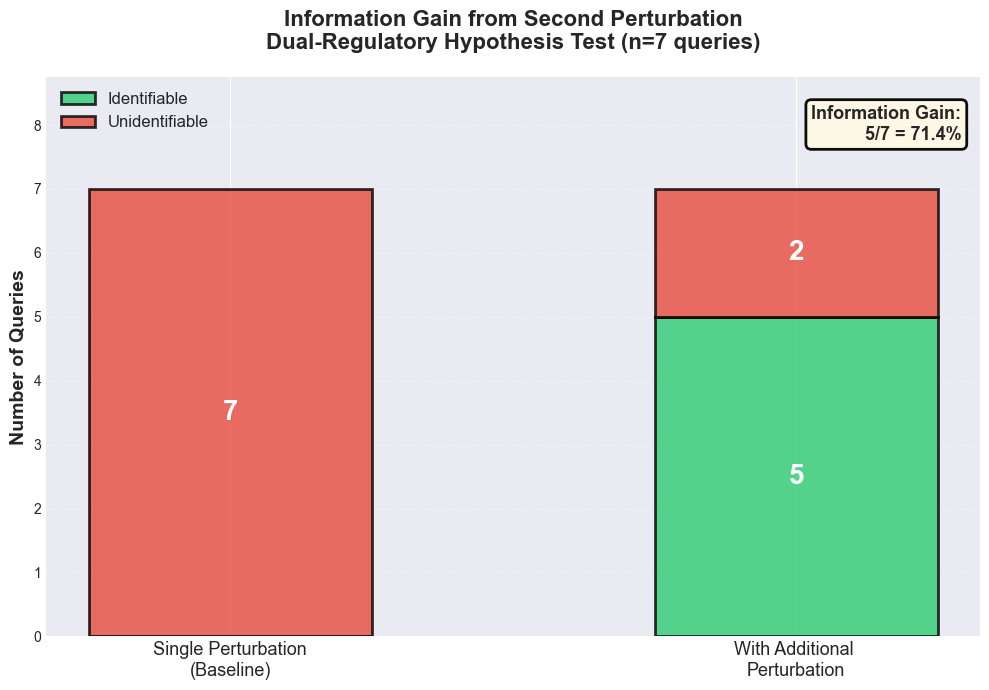

In [ ]:
"""
What is the impact/information gain of adding another perturbation? 
"""

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Create figure
fig, ax = plt.subplots(figsize=(10, 7))

# Data
categories = ["Single Perturbation\n(Baseline)", "With Additional \nPerturbation"]
x = np.arange(len(categories))
width = 0.5

baseline_unidentifiable = len(two_parent_opportunities)  # All 7 were unidentifiable
with_context_identifiable = confirmed
with_context_unidentifiable = total - confirmed

# Stacked bars
identifiable_counts = [0, with_context_identifiable]
unidentifiable_counts = [baseline_unidentifiable, with_context_unidentifiable]

bars1 = ax.bar(
    x,
    identifiable_counts,
    width,
    label="Identifiable",
    color="#2ecc71",
    alpha=0.8,
    edgecolor="black",
    linewidth=2,
)
bars2 = ax.bar(
    x,
    unidentifiable_counts,
    width,
    bottom=identifiable_counts,
    label="Unidentifiable",
    color="#e74c3c",
    alpha=0.8,
    edgecolor="black",
    linewidth=2,
)

# Add value labels
for i, (id_c, unid_c) in enumerate(zip(identifiable_counts, unidentifiable_counts)):
    if id_c > 0:
        ax.text(
            i,
            id_c / 2,
            f"{id_c}",
            ha="center",
            va="center",
            fontsize=20,
            fontweight="bold",
            color="white",
        )
    if unid_c > 0:
        ax.text(
            i,
            id_c + unid_c / 2,
            f"{unid_c}",
            ha="center",
            va="center",
            fontsize=20,
            fontweight="bold",
            color="white",
        )

# a little styling
ax.set_ylabel("Number of Queries", fontsize=14, fontweight="bold")
ax.set_title(
    "Information Gain from Second Perturbation\n"
    f"Dual-Regulatory Hypothesis Test (n={total} queries)",
    fontsize=16,
    fontweight="bold",
    pad=20,
)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=13)
ax.set_ylim(0, baseline_unidentifiable * 1.25)
ax.legend(loc="upper left", fontsize=12, framealpha=0.9)  # shifted to upper left now for the legend
ax.grid(axis="y", alpha=0.3, linestyle="--")

# Add success rate annotation - moved to upper right corner
ax.text(
    0.98,
    0.95,
    f"Information Gain:\n{confirmed}/{total} = {confirmed / total * 100:.1f}%",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=13,
    fontweight="bold",
    bbox=dict(boxstyle="round", facecolor="#fff9e6", alpha=0.95, edgecolor="black", linewidth=2),
)

plt.tight_layout()
plt.savefig("information_gain_dual_regulatory.png", dpi=300, bbox_inches="tight")
plt.show()